<a href="https://colab.research.google.com/github/montimaj/GeoE-6001-Space/blob/main/Lab2/rs_hydro_lab2_Sayantan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2

In this lab, you will use python (and a module called Google Earth Engine) to view satellite imagery, and access precipitation datasets.

Before starting the sections, we will import the modules we need, initialize Google Earth Engine, and define some functions.

The first block of code only needs to be run once, the first time you open your session (if you close out of the session and open again, you will need to run this again). Follow the prompts to initialize earth engine. You will be taken to a link where you need to give permission to link your google account with Google Earth Engine, then copy and paste some text below the code block.

In [ ]:
import ee
import folium
import numpy as np
import branca.colormap as cm

from google.colab import drive
drive.mount('/content/drive/')

ee.Authenticate()
ee.Initialize()

Mounted at /content/drive/
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=8Z5KlQ6x8SQD0jHtKtnkKKXtgT_38FK-rl0Nnx8BjDI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWijzUD9zwVFUPNDZ88_Sxb9MjDXbmIDxZ190wGqimVy7u2YjN_lQ5A

Successfully saved authorization token.


This block of code also only needs to be run once. It is defining a bunch of functions that you will use in this exercise. It is not important for you to understand the code here for this exercise.

In [ ]:
# functions needed for this lab (and some other useful ones that you can use if you're interested)

# to add a layer to our map:
def add_ee_layer(self, ee_object, name):
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):  
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except Exception as e:
        print("Could not display {}".format(name))
        print(e)

# to convert a google earth engine image to a python array
def to_array(img,aoi):
  band_arrs = img.sampleRectangle(region=aoi,properties=['scale=1000'],defaultValue=-999)

  band_names=img.bandNames().getInfo()

  for kk in range(len(band_names)):
    if kk==0:
      dat1=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full=np.zeros((dat1.shape[0],dat1.shape[1],len(band_names)))
      dat_full[:,:,kk]=dat1
    else:
      dat=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full[:,:,kk]=dat
  return(dat_full)

# to calculate an index
def getIndex(image,b1,b2):
  return image.normalizedDifference([b1, b2])

# to calculate a ratio
def getRatio(image1,image2):
  ratio=image1.divide(image2)
  return ratio

# to create a color map from a specific image
def getVisparams(image,aoi):
  range = image.reduceRegion(ee.Reducer.percentile([1, 99]),aoi,300)
  vals = range.getInfo()
  min=list(vals.items())[0][1]
  max=list(vals.items())[1][1]
  visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(visParams)

# to get the link to download an earth engine image
def getLink(image,aoi):
  link = image.getDownloadURL({
    'scale': 1000,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi})
  print(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  import ee
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

# load prism data
def get_prism_image(date1,date2,geometry, operation='mean'):
  import ee
  prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81m')
  if operation == 'mean':
    prism_img = prism.filterDate(date1,date2).select('ppt').mean().clip(geometry)
  else:
    prism_img = prism.filterDate(date1,date2).select('ppt').sum().clip(geometry)
  return(prism_img) # returns prism average monthly or total precipitation, in mm depending on the operation

# load landsat 8 data
def get_l8_image(date1,date2,geometry):
  import ee
  l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT')
  l8_img = l8.filterDate(date1,date2).mean().clip(geometry)
  return(l8_img)

def export_to_drive(raster,filename,foldername,geometry):
  # Export the image, specifying scale and region.
  task = ee.batch.Export.image.toDrive(**{
      'image': raster,
      'description': filename,
      'folder': foldername,
      'fileNamePrefix': filename,
      'scale': 1000,
      'region': geometry,
      'fileFormat': 'GeoTIFF',
      'formatOptions': {
        'cloudOptimized': 'true'
      },
  })
  task.start()

def get_elev(geometry):
  import ee
  elev = ee.Image('USGS/NED').clip(geometry)
  return(elev)

def get_srtm(geometry):
  import ee
  elev = ee.Image('USGS/SRTMGL1_003').clip(geometry)
  return(elev)

def get_gpm_image(date1,date2,geometry, operation='mean'):
  import ee
  gpm = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')
  if operation == 'mean':
    gpm_img = gpm.filterDate(date1,date2).select('precipitation').mean().multiply(24*365/12).clip(geometry)
  else:
    gpm_img = gpm.filterDate(date1,date2).select('precipitation').sum().multiply(24*365/12).clip(geometry)
  return(gpm_img) # returns gpm average monthly or total precipitation in mm depending on the operation

# load sentinel 2 data
def get_s2_image(date1,date2,geometry):
    import ee
    s2 = ee.ImageCollection('COPERNICUS/S2')
    s2_img = s2.filterDate(date1,date2).filterBounds(geometry).first().clip(geometry)
    return(s2_img)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Part 1: Viewing precipitation data for a given geometry and date

 

First, we will define the study area and time period and load some PRISM, GPM and elevation data.

In [ ]:
# create a bounding box that defines the study area
geom = addGeometry(-110, -105,40,45) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2020-04-01'
end = '2021-04-01' #can go up to april 2021

# get elevation data
elev = get_elev(geom)

# now get gpm precipitation over the same region for a specified time period
gpm_img = get_gpm_image(start,end,geom)

# now get prism precipitation over the same time period/region
prism_img = get_prism_image(start,end,geom)

Now, we will view the map. Scroll to the top so you can check/uncheck layers. Take a screenshot for your lab report.

In [ ]:
my_map = folium.Map(location=[42.5, -107], zoom_start=6)

# Add the land cover to the map object.
#my_map.add_ee_layer(l8_img,'Landsat 8')
my_map.add_ee_layer(elev,'Elevation')
my_map.add_ee_layer(prism_img,'PRISM precip')
my_map.add_ee_layer(gpm_img,'GPM precip')

my_map.add_ee_layer(geom,'bounding box')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Now, we will export the tiffs to your Google Colab folder (this is a folder in your Google Drive storage). We will then use some other python functions to do analysis. After you run the code below, it will take a few minutes to save the files to your Google Drive. Move on to the next step while you're waiting.

In [ ]:
export_to_drive(gpm_img,'lab2_gpm_precip_CO','Colab Notebooks',geom) # raster, file name, folder name, geometry to clip it with
export_to_drive(elev,'lab2_elev_CO','Colab Notebooks',geom)
export_to_drive(prism_img,'lab2_prism_precip_CO','Colab Notebooks',geom)

While you're waiting, try a different way of downloading the rasters below. Once you have downloaded them, load them into QGIS. Reproject the elevation dataset to a projected coordinate reference system (UTM Zone 15N, WGS84 is a good choice). You can do this by right-clicking on the elevation file, Export, then specify the coordinate reference system.

Calculate the slope of the projected coordinate reference system (Raster -> Analysis -> Slope).

Identify an area with high landslide risk (high slope/high precipitation), and make a shapefile  over that region.

Take a screenshot and include with your report.

The precipitation units are the average monthly precipitation in mm. What is the maximum/minimum total precipitation over the study period?

In [49]:
# create a bounding box that defines the study area
geom = addGeometry(-110, -105,40,45) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2020-04-01'
end = '2021-04-01' #can go up to april 2021

# now get gpm precipitation over the same region for a specified time period
gpm_img_total = get_gpm_image(start,end, geom, 'sum')

# now get prism precipitation over the same time period/region
prism_img_total = get_prism_image(start,end, geom, 'sum')

gpm_total_arr = to_array(gpm_img_total, geom)
prism_total_arr = to_array(prism_img_total, geom)

min_gpm, max_gpm = np.round(np.min(gpm_total_arr), 2), np.round(np.max(gpm_total_arr), 2)
min_prism, max_prism = np.round(np.min(prism_total_arr), 2), np.round(np.max(prism_total_arr), 2)

print('GPM stats (min, max) = ({}, {})'.format(min_gpm, max_gpm))
print('PRISM stats (min, max) = ({}, {})'.format(min_prism, max_prism))

GPM stats (min, max) = (161.32, 305.84)
PRISM stats (min, max) = (128.91, 558.16)


In [ ]:
print('GPM precipitation raster download:')
getLink(gpm_img,geom)
print('Elevation raster download:')
getLink(elev,geom)
print('PRISM precipitation raster download:')
getLink(prism_img,geom)

GPM precipitation raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dadaefcfab58ff3a06abb62f10dcc914-75a4ec19bbfd28fdcf3d1e12555b6ae0:getPixels
Elevation raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7c3a338c8f2338473c77398ba6ed511-cf77356f200d585ab2652e2735ce2a16:getPixels
PRISM precipitation raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5dc49404de36aefbda78341973e195b-3a4626c79cd3fa92869fd8fca60ede73:getPixels


Now, we will load the rasters we just downloaded with a separate python package--rasterio--and compare GPM with PRISM.

In [ ]:
!pip install rasterio
import rasterio
from rasterio.warp import reproject
import matplotlib.pyplot as plt

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


Click on the 'Files' tab on the left. Go to drive > MyDrive > Colab Notebooks. You should see some '.tif' files for prism, gpm and elevation data. If you don't see them yet, you may have to wait a few minutes for them to get saved to the cloud.

Now you will load the rasters into python with rasterio. This package works more easily with the usual python packages, making plotting easier.

In [ ]:
folder_location='drive/MyDrive/Colab Notebooks/'
gpm=rasterio.open(folder_location+'lab2_gpm_precip_CO.tif')
prism=rasterio.open(folder_location+'lab2_prism_precip_CO.tif')
elev=rasterio.open(folder_location+'lab2_elev_CO.tif')

Now, we will make a crossplot of PRISM and GPM data, with points colored by elevation. PRISM are considered more accurate generally. Comment on the accuracy of the GPM data.

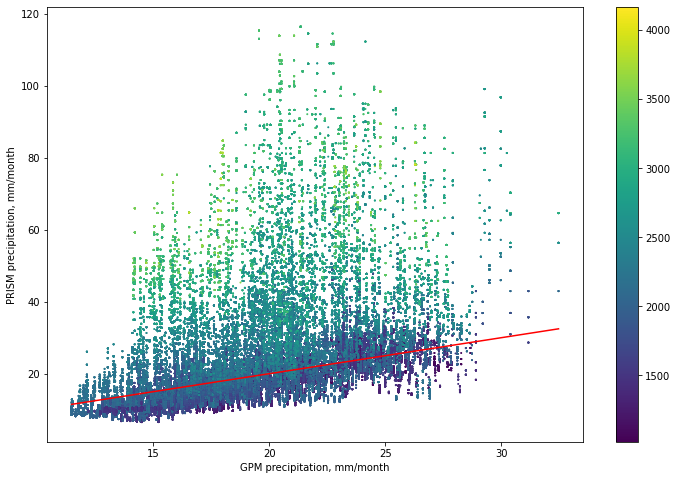

In [ ]:
gpm_flat=gpm.read().flatten()
prism_flat=prism.read().flatten()
elev_flat=elev.read().flatten()
plt.figure(figsize=(12,8));plt.scatter(gpm_flat,prism_flat,c=elev_flat,s=1)
reference_line=[np.nanmin(gpm_flat),np.nanmax(gpm_flat)]
plt.plot(reference_line,reference_line,'r')
plt.xlabel('GPM precipitation, mm/month')
plt.ylabel('PRISM precipitation, mm/month')
plt.colorbar()

# Part 2: Repeat the above process, but this time do it over the study area for your term project

If you haven't decided on a location for your project yet, you can select an area you are considering for your term project. It's OK to change later.

You will need to 'fill in the blanks' for the code below.

In [58]:
# create a bounding box that defines the study area. This will cover the Lake of the Ozarks region
geom_study_area = addGeometry(-110.0775886034469,-109.54887156243127,32.04959954799513,32.5047418453504) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2020-04-01'
end = '2020-10-01'

# use the tools in the example from Part 1 to pull GPM precip and elevation data. 
# NOTE: if you are workin in a region outside of the US, the get_elev function will not work
# (it uses the National Elevation Dataset which only covers the US). Use the get_srtm function instead

# get elevation data
elev = get_elev(geom_study_area)

# now get gpm precipitation over the same region for a specified time period
gpm_img = get_gpm_image(start, end, geom_study_area)

prism_img = get_prism_image(start, end, geom_study_area)


Now, you will display the map. Try at least three different indices. Include a screenshot and description of what wavelengths you used for each one in your lab report.

In [33]:
l8_image = get_l8_image(start, end, geom_study_area)

l8_ndvi = getIndex(l8_image, 'B5', 'B4')
l8_ndwi = getIndex(l8_image, 'B5', 'B6')

l8_b5 = l8_image.select(['B5'])
l8_b4 = l8_image.select(['B4'])
l8_b2 = l8_image.select(['B2'])


# Enhanced Vegetation Index (https://www.usgs.gov/core-science-systems/nli/landsat/landsat-enhanced-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con)
evi_numerator = l8_b5.subtract(l8_b4)
t1 = l8_b4.multiply(6)
t2 = l8_b2.multiply(7.5)
t = t1.subtract(t2).add(1)
evi_denominator = l8_b5.add(t)
l8_evi = evi_numerator.divide(evi_denominator)
l8_evi = l8_evi.multiply(2.5)


In [34]:
my_map = folium.Map(location=[32.24, -109.83], zoom_start=6) # location values should be lat, lon. zoom_start: lower values are more zoomed out. Adjust until it looks right.

# Add the land cover to the map object.

my_map.add_ee_layer(l8_ndvi,'Landsat 8 NDVI')
my_map.add_ee_layer(l8_ndwi,'Landsat 8 NDWI')
my_map.add_ee_layer(l8_evi,'Landsat 8 EVI')
my_map.add_ee_layer(geom_study_area,'bounding box')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Download these rasters and display in QGIS as you did before. Repeat the same exercise -- reproject the elevation to a projected CRS, then calculate slope and identify an area of high landslide risk.

As before, determine the average precipitation over the study period.

In [50]:
export_to_drive(gpm_img,'lab2_gpm_precip_Wilcox','Colab Notebooks', geom_study_area) # raster, file name, folder name, geometry to clip it with
export_to_drive(elev,'lab2_elev_Wilcox','Colab Notebooks', geom_study_area)
export_to_drive(prism_img,'lab2_prism_precip_Wilcox','Colab Notebooks', geom_study_area)

In [59]:
print('Elevation raster download:')
getLink(elev, geom_study_area)
print('GPM precipitation raster download:')
getLink(gpm_img, geom_study_area)
print('PRISM precipitation raster download')
getLink(prism_img, geom_study_area)

Elevation raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/222f2f4acb85db3a092b514c4eb076df-ee41afd12b8d6055b24df09bb4cfb5a9:getPixels
GPM precipitation raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1dc266f19a6a67f62587a7b327ec7fb1-48ab543d216487ed0965a40dcf477f33:getPixels
PRISM precipitation raster download
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd8fc7a90cee468400c796367dcd1de2-0d98fc49472afd5ead39b05d951bae8d:getPixels


In [62]:
# create a bounding box that defines the study area. This will cover the Lake of the Ozarks region
geom_study_area = addGeometry(-110.0775886034469,-109.54887156243127,32.04959954799513,32.5047418453504) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2020-04-01'
end = '2020-10-01'

# now get gpm precipitation over the same region for a specified time period
gpm_img_total = get_gpm_image(start, end, geom_study_area, 'sum')

# now get prism precipitation over the same time period/region
prism_img_total = get_prism_image(start, end, geom_study_area, 'sum')

gpm_total_arr = to_array(gpm_img_total, geom_study_area)
prism_total_arr = to_array(prism_img_total, geom_study_area)

min_gpm, max_gpm = np.round(np.min(gpm_total_arr), 2), np.round(np.max(gpm_total_arr), 2)
min_prism, max_prism = np.round(np.min(prism_total_arr), 2), np.round(np.max(prism_total_arr), 2)

print('GPM stats (min, max) = ({}, {})'.format(min_gpm, max_gpm))
print('PRISM stats (min, max) = ({}, {})'.format(min_prism, max_prism))

GPM stats (min, max) = (69.72, 85.65)
PRISM stats (min, max) = (50.04, 53.07)


If you'd like to get more familiar with python, try creating a new code block to do the same analysis as before (load the rasters with rasterio, then make a crossplot). It's mostly just copying code from above, and changing filenames. This part is not required, but if you try it, you will get more comfortable with python.

In [55]:
folder_location = 'drive/MyDrive/Colab Notebooks/'
gpm = rasterio.open(folder_location+'lab2_gpm_precip_Wilcox.tif')
prism = rasterio.open(folder_location+'lab2_prism_precip_Wilcox.tif')
elev = rasterio.open(folder_location+'lab2_elev_Wilcox.tif')

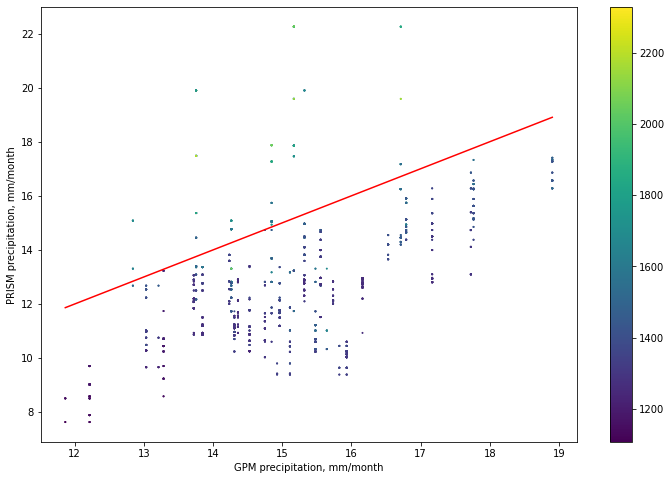

In [56]:
gpm_flat = gpm.read().flatten()
prism_flat = prism.read().flatten()
elev_flat = elev.read().flatten()
plt.figure(figsize=(12, 8));plt.scatter(gpm_flat, prism_flat, c=elev_flat, s=1)
reference_line=[np.nanmin(gpm_flat),np.nanmax(gpm_flat)]
plt.plot(reference_line,reference_line, 'r')
plt.xlabel('GPM precipitation, mm/month')
plt.ylabel('PRISM precipitation, mm/month')
plt.colorbar()

Wilcox is an arid region and the study area is not big enough to have an appropriate scatter plot comparison because of the coarser resolution of the GPM precipitation data.